# Präsenzversuch zum Laval-Rotor

Name: Ole Quiring 
Datum:  5.2.2024
Gruppe:48

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: In welchem Maße sticht die Resonanzfrequenz bei einem schwingendem System heraus und wie kann ich das messen?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="IMG-20240202-WA0010.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Eine 0.75 Meter lange Stange mit 10 Millimeter Durchmesser hat eine 950 Gramm Stahlscheibe mit Durchmesser 99 Millimeter und dicke 15 Millimeter exzentrisch auf sich montiert. Das gesamte System wird rotiert und die exzentrische Montage lässt das System bei Eigenfrequenzen stark auf und ab schwingen.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_105207_lavalrotor_48_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000
velocity=[]
drehungszahl=[]
timestamp=[]
amplitude=[]
frequency=[]
int_data=[]
pathh5=path_measurement_folder+"/"+filename
        
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)            

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions
with h5py.File(pathh5, 'r') as hdf5_file:
    for folder_name in map(str, range(20)):
        if folder_name in hdf5_file:
            folder = hdf5_file[folder_name]
            acceleration_x = folder["RawData"][uuid_acceleration]["acceleration_x"]
            acceleration_y = folder["RawData"][uuid_acceleration]["acceleration_y"]
            acceleration_z = folder["RawData"][uuid_acceleration]["acceleration_z"]
            velocity.append(m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z))
            timestamp.append(folder["RawData"][uuid_acceleration]["timestamp"][()])
            motor_rpm = folder["RawData"][uuid_motor_rpm]["motor_rpm"]
            drehungszahl.append(motor_rpm[()])
            
for i in range(len(drehungszahl)):
    int_data.append(m_postprocessing.interpolation(timestamp[i],velocity[i],interpolation_points))            

for i in range(len(int_data)):
    amplitude1,frequency1=m_postprocessing.my_fft_scaled(int_data[i],interpolation_points)
    amplitude.append(amplitude1)
    frequency.append(frequency1)
 

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

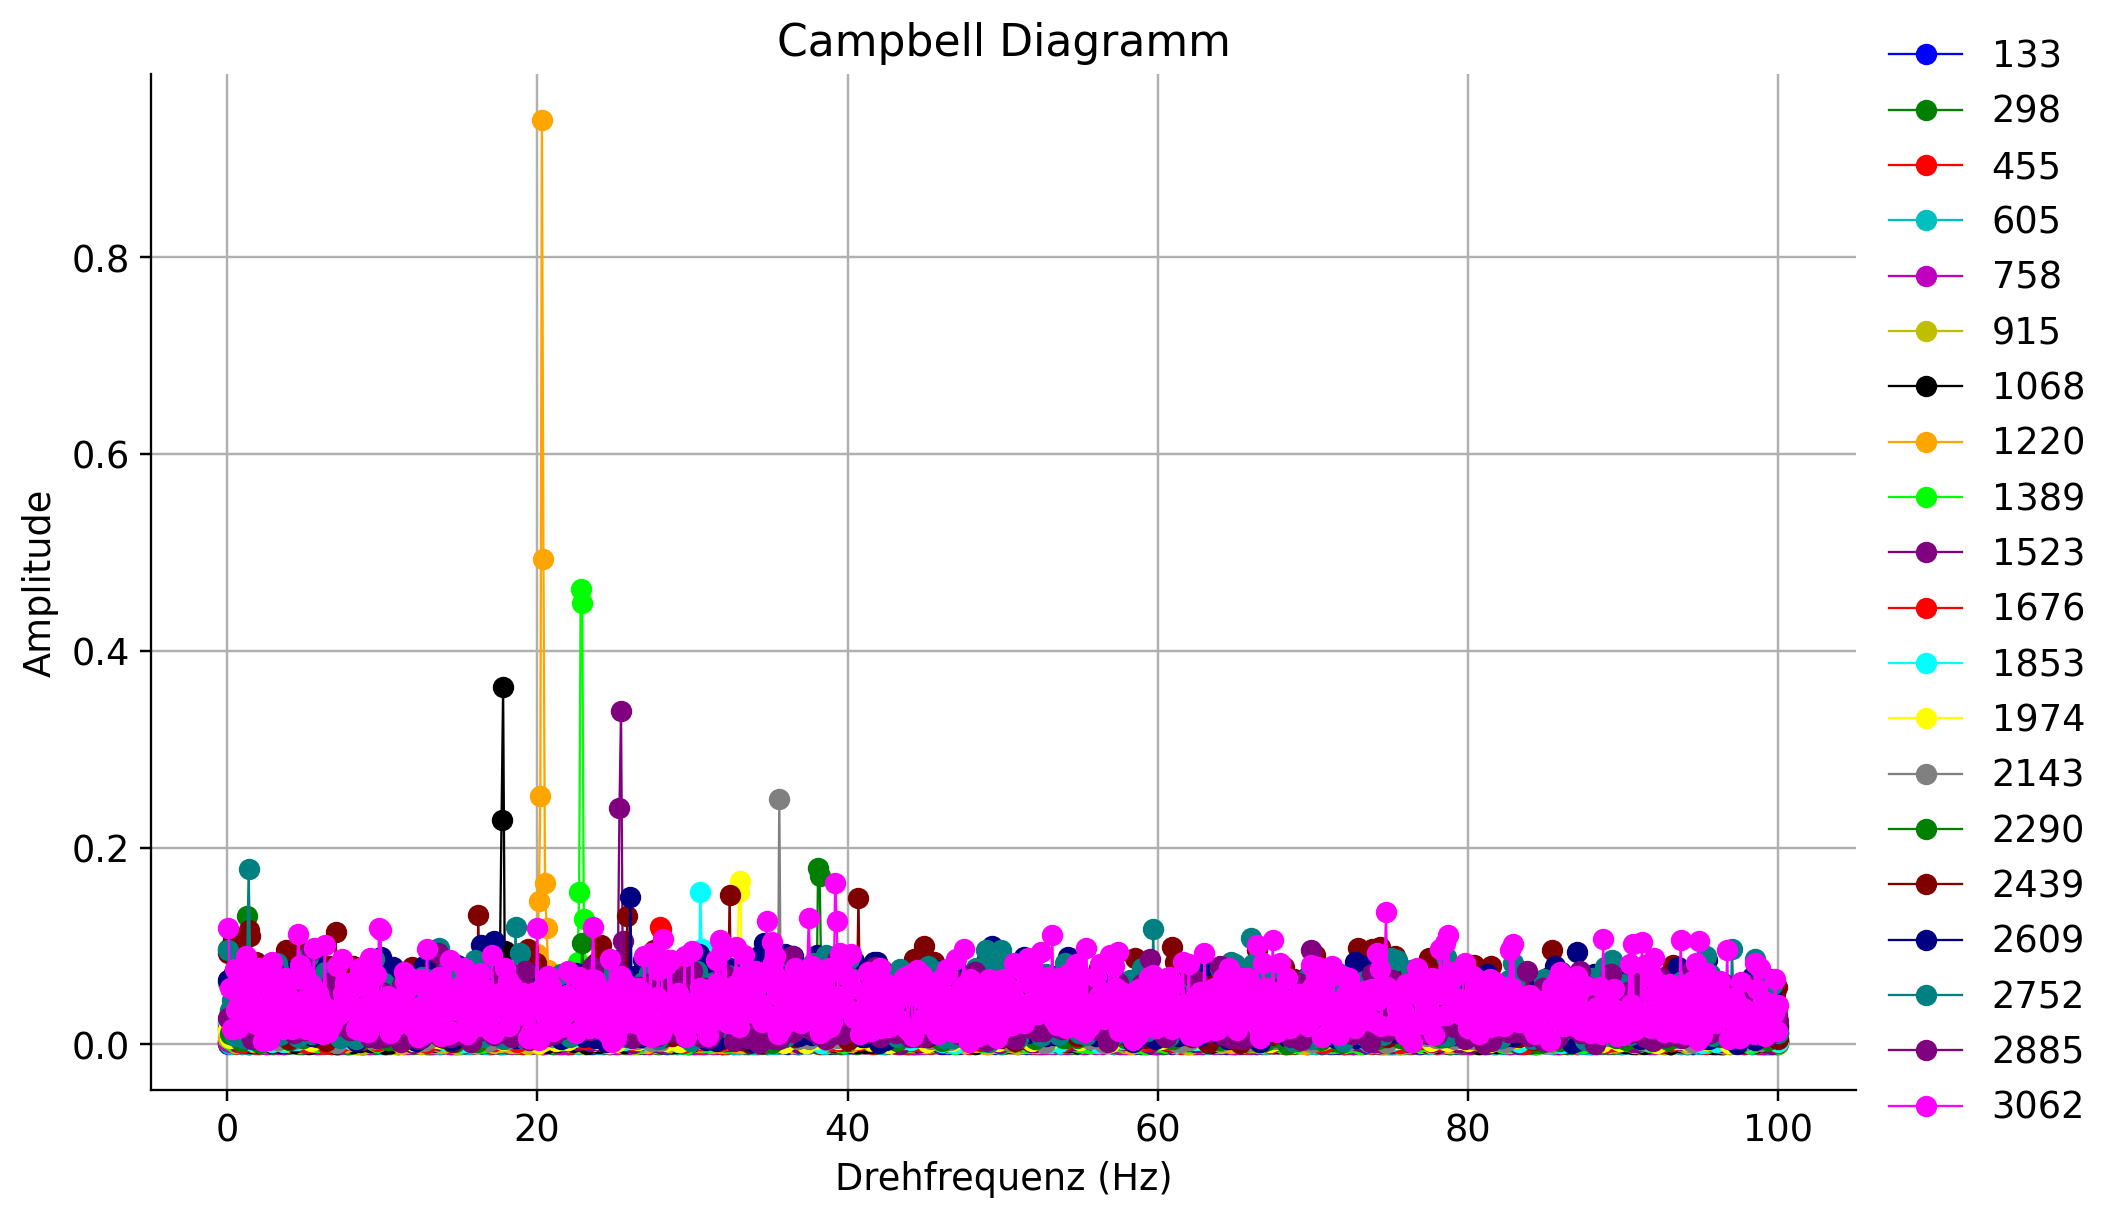

In [6]:
plt.figure(figsize=(10, 6))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080','#FF0000', '#00FFFF', '#FFFF00', '#808080', '#008000', '#800000','#000080', '#008080', '#800080', '#FF00FF']
for i in range(len(amplitude)):
    plt.plot(frequency[i], amplitude[i], 'o-', label=drehungszahl[i],color=colors[i % len(colors)])
plt.title('Campbell Diagramm')
plt.xlabel('Drehfrequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Zweiter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

measurement_time_in_s = 10
number_interpolation_points = 2000
velocity=[]
drehungszahl=[]
timestamp=[]
amplitude=[]
frequency=[]
int_data=[]
pathh5=path_measurement_folder+"/"+filename
        
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)            

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions
with h5py.File(pathh5, 'r') as hdf5_file:
    for folder_name in map(str, range(20)):
        if folder_name in hdf5_file:
            folder = hdf5_file[folder_name]
            acceleration_x = folder["RawData"][uuid_acceleration]["acceleration_x"]
            acceleration_y = folder["RawData"][uuid_acceleration]["acceleration_y"]
            acceleration_z = folder["RawData"][uuid_acceleration]["acceleration_z"]
            velocity.append(m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z))
            timestamp.append(folder["RawData"][uuid_acceleration]["timestamp"][()])
            motor_rpm = folder["RawData"][uuid_motor_rpm]["motor_rpm"]
            drehungszahl.append(motor_rpm[()])
            
for i in range(len(drehungszahl)):
    int_data.append(m_postprocessing.interpolation(timestamp[i],velocity[i],interpolation_points))            

for i in range(len(int_data)):
    amplitude1,frequency1=m_postprocessing.my_fft_scaled(int_data[i],interpolation_points)
    amplitude.append(amplitude1)
    frequency.append(frequency1)

#### 3. Darstellung mittels Campbell-Diagramm

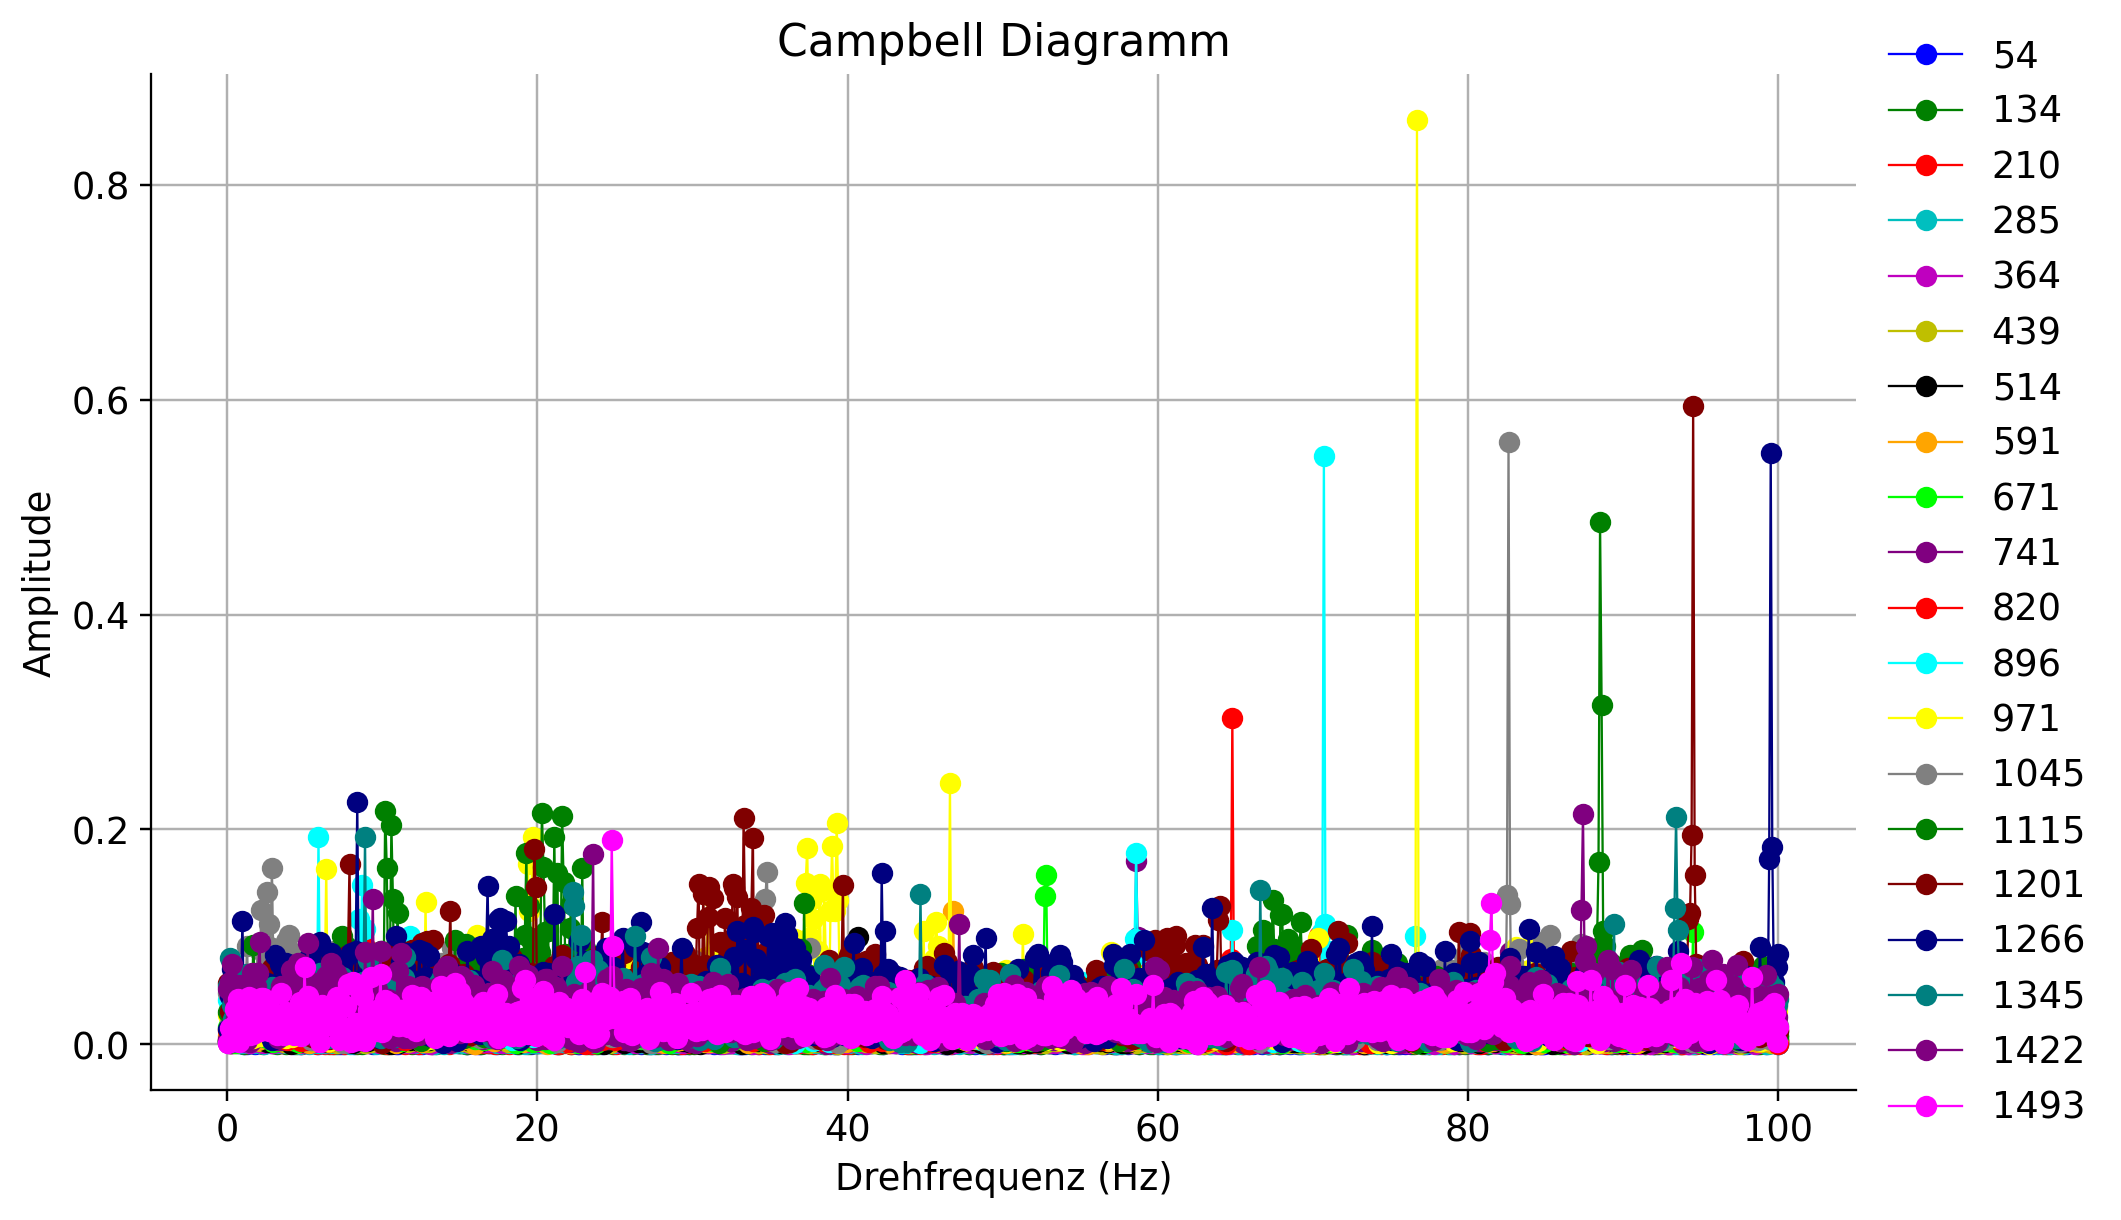

In [9]:
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080','#FF0000', '#00FFFF', '#FFFF00', '#808080', '#008000', '#800000','#000080', '#008080', '#800080', '#FF00FF']
for i in range(len(amplitude)):
    plt.plot(frequency[i], amplitude[i], 'o-', label=drehungszahl[i],color=colors[i % len(colors)])
plt.title('Campbell Diagramm')
plt.xlabel('Drehfrequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

measurement_time_in_s = 10
number_interpolation_points = 2000
velocity=[]
drehungszahl=[]
timestamp=[]
amplitude=[]
frequency=[]
int_data=[]
pathh5=path_measurement_folder+"/"+filename
        
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)            

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions
with h5py.File(pathh5, 'r') as hdf5_file:
    for folder_name in map(str, range(20)):
        if folder_name in hdf5_file:
            folder = hdf5_file[folder_name]
            acceleration_x = folder["RawData"][uuid_acceleration]["acceleration_x"]
            acceleration_y = folder["RawData"][uuid_acceleration]["acceleration_y"]
            acceleration_z = folder["RawData"][uuid_acceleration]["acceleration_z"]
            velocity.append(m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z))
            timestamp.append(folder["RawData"][uuid_acceleration]["timestamp"][()])
            motor_rpm = folder["RawData"][uuid_motor_rpm]["motor_rpm"]
            drehungszahl.append(motor_rpm[()])
            
for i in range(len(drehungszahl)):
    int_data.append(m_postprocessing.interpolation(timestamp[i],velocity[i],interpolation_points))            

for i in range(len(int_data)):
    amplitude1,frequency1=m_postprocessing.my_fft_scaled(int_data[i],interpolation_points)
    amplitude.append(amplitude1)
    frequency.append(frequency1)

#### 3. Darstellung mittels Campbell-Diagramm

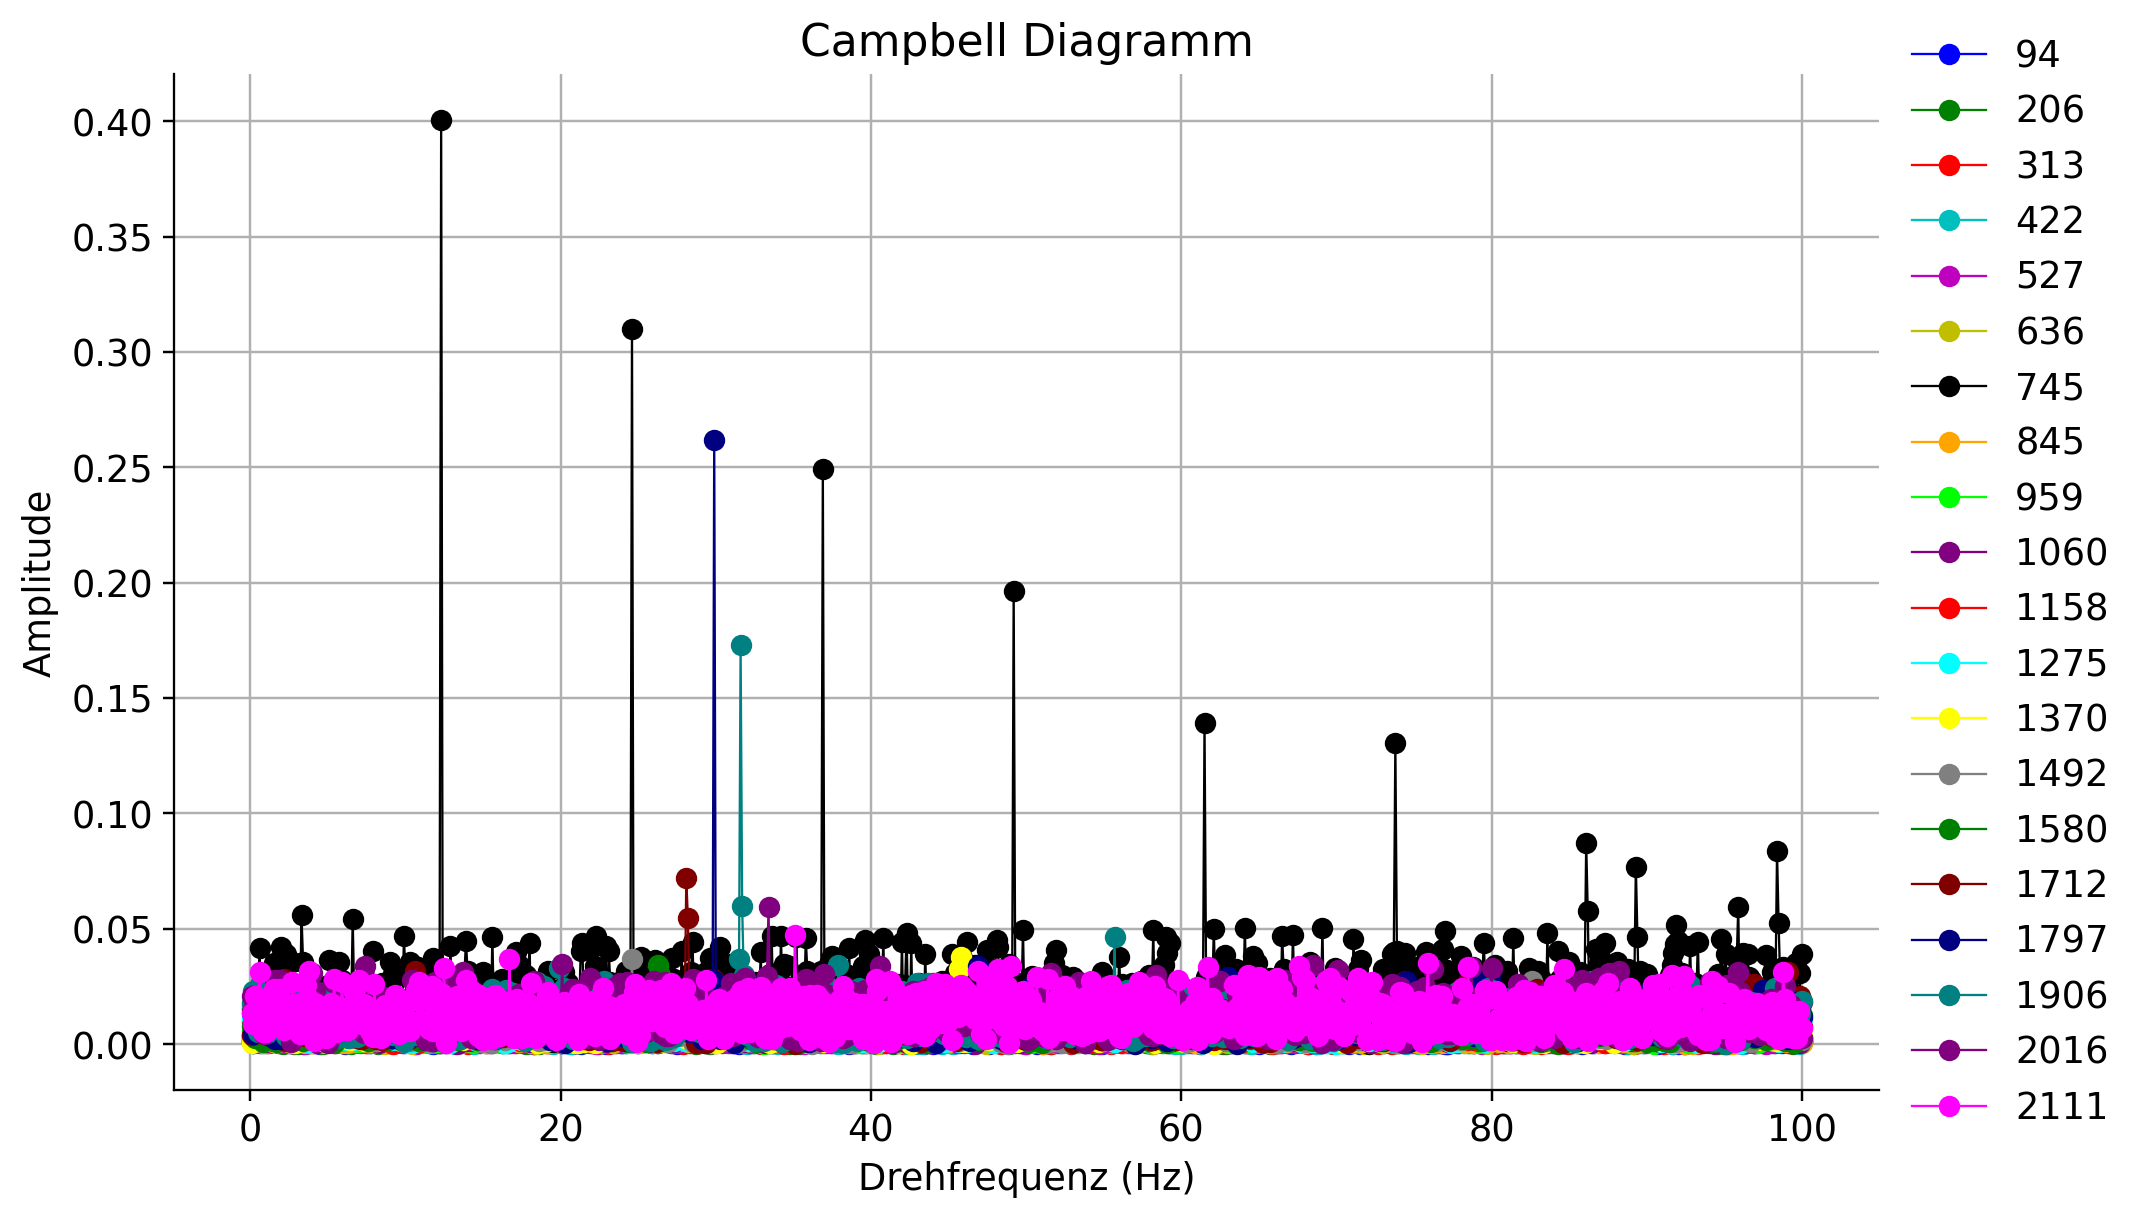

In [12]:
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080','#FF0000', '#00FFFF', '#FFFF00', '#808080', '#008000', '#800000','#000080', '#008080', '#800080', '#FF00FF']
for i in range(len(amplitude)):
    plt.plot(frequency[i], amplitude[i], 'o-', label=drehungszahl[i],color=colors[i % len(colors)])
plt.title('Campbell Diagramm')
plt.xlabel('Drehfrequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Ergebnisse haben gut gezeigt bei welchen Frequenzen die Systeme stärker schwingen und wie man im nächstem Textfeld auch sieht, stimmt die Eigenfrequenz mit der errechneten überein. Die Resonanzfrequenzen stechen stark heraus und haben sich relativ gut messen lassen.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

#Die Eigenfrequenz ist n= 60*w/(2*pi) mit w=sqrt(k/m) und k=48*E*I/(L^3) bei dem I =(pi*d^4)/64 ist. Somit ergibt sich für die folgenden Werte:
m=0.95
E=210000
d=99
L=750
die Umdrehungszahl n=1061, welche relativ gut zu den gemessenen Werten passt.


## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Experiment ist ein Erfolg, da die Hypothese und die gemessenen Werte übereinstimmen. Ich habe mehr über Datenanalyse gelernt und fand das Experiment interessant.